## 차년도 발주를 위한 발주수량 예측

### 1. 데이터 불러오기 및 전처리
---

In [ ]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

# 경로 설정(정보 생략)
import os
os.chdir()
os.getcwd()

In [ ]:
# Data read
import pandas as pd
df = pd.read_excel("chapter20_order.xlsx")
df = pd.DataFrame(df)
df.head(10)

,Date,M3
0,2012-01-01,27
1,2012-02-01,37
2,2012-03-01,8
3,2012-04-01,9
4,2012-05-01,11
5,2012-06-01,7
6,2012-07-01,5
7,2012-08-01,8
8,2012-09-01,23
9,2012-10-01,4


In [ ]:
# Data 형태 확인
print('df', df.shape) # 82, 2

df (82, 2)


In [ ]:
# Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    82 non-null     datetime64[ns]
 1   M3      82 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 KB


In [ ]:
# Null 값 확인
print(df.isnull().sum())

Date    0
M3      0
dtype: int64


In [ ]:
# Outlier 확인
df.describe()

,M3
count,82.000000
mean,82.134146
std,79.807138
min,2.000000
25%,26.250000
50%,53.500000
75%,131.000000
max,393.000000


### 2. 발주 추이 분석
---

In [ ]:
df.head(5)

,Date,M3
0,2012-01-01,27
1,2012-02-01,37
2,2012-03-01,8
3,2012-04-01,9
4,2012-05-01,11


In [ ]:
df['Date'].min(), df['Date'].max() 

(Timestamp('2012-01-01 00:00:00'), Timestamp('2018-10-01 00:00:00'))

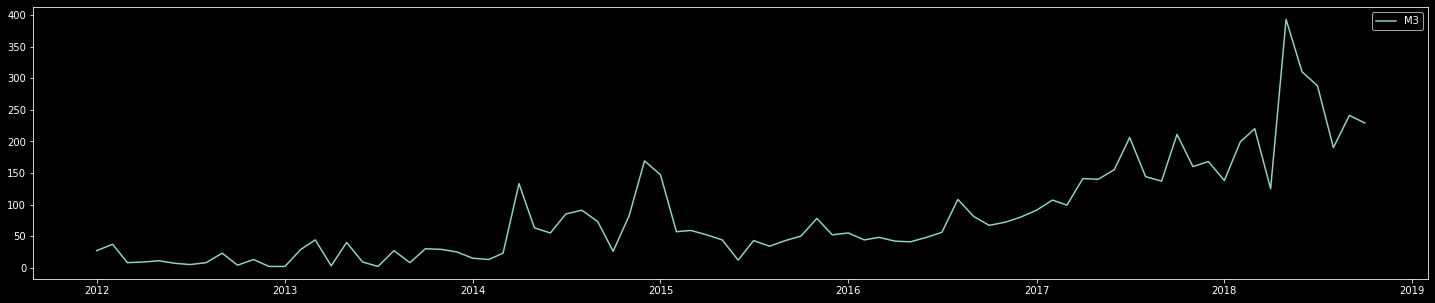

In [ ]:
# 전체 기간 Plotting 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

plt.plot(df['Date'], df['M3'], label='M3');
plt.legend();
plt.gcf().set_size_inches(25, 5)

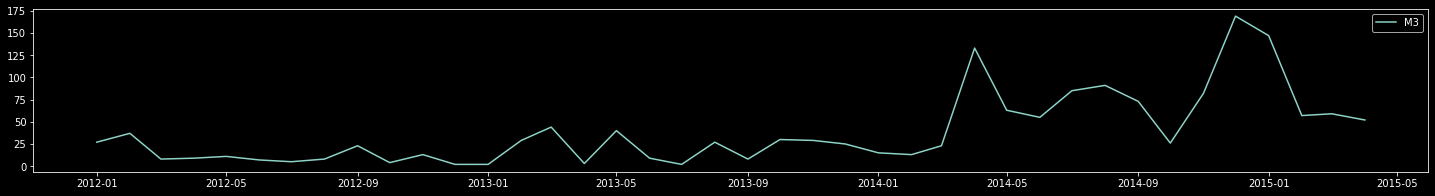

In [ ]:
# 일부 기간 Plotting [0:40]
plt.plot(df['Date'][0:40], df['M3'][0:40], label='M3');
plt.legend();
plt.gcf().set_size_inches(25, 3)

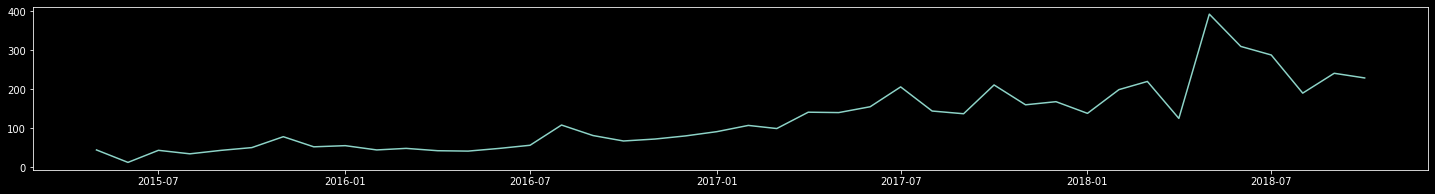

In [ ]:
# 일부 기간 Plotting [40:]
plt.plot(df['Date'][40:], df['M3'][40:], label='M3');
plt.gcf().set_size_inches(25, 3)

In [ ]:
df.head(5)

,Date,M3
0,2012-01-01,27
1,2012-02-01,37
2,2012-03-01,8
3,2012-04-01,9
4,2012-05-01,11


In [ ]:
# 월 별 비교
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df.head(5)

,Date,M3,year,month
0,2012-01-01,27,2012,1
1,2012-02-01,37,2012,2
2,2012-03-01,8,2012,3
3,2012-04-01,9,2012,4
4,2012-05-01,11,2012,5


In [ ]:
# pivot table을 활용 년도별 월별 자재 발주량 비교
df_pivot = pd.pivot_table(df, index = 'year', columns = 'month', values = 'M3')
df_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2012,27.0,37.0,8.0,9.0,11.0,7.0,5.0,8.0,23.0,4.0,13.0,2.0
2013,2.0,29.0,44.0,3.0,40.0,9.0,2.0,27.0,8.0,30.0,29.0,25.0
2014,15.0,13.0,23.0,133.0,63.0,55.0,85.0,91.0,73.0,26.0,82.0,169.0
2015,147.0,57.0,59.0,52.0,44.0,12.0,43.0,34.0,43.0,50.0,78.0,52.0
2016,55.0,44.0,48.0,42.0,41.0,48.0,56.0,108.0,81.0,67.0,72.0,80.0
2017,91.0,107.0,99.0,141.0,140.0,155.0,206.0,144.0,137.0,211.0,160.0,168.0
2018,138.0,199.0,220.0,125.0,393.0,310.0,288.0,190.0,241.0,229.0,NaN,NaN


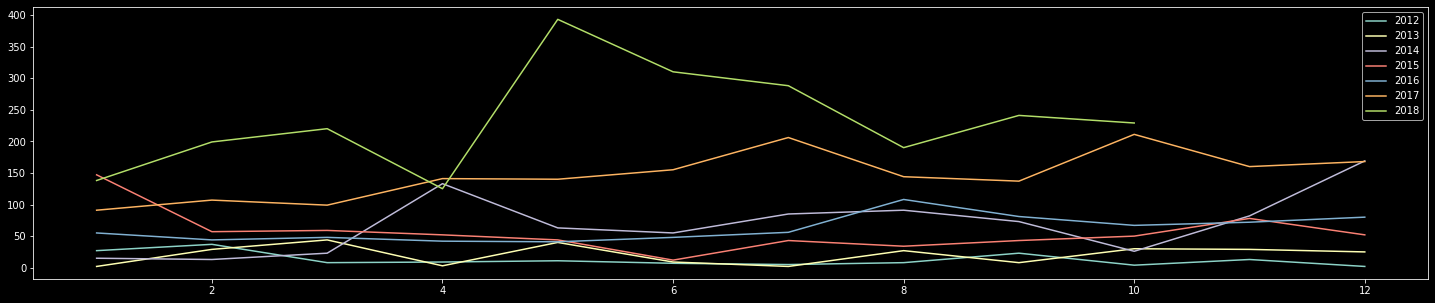

In [ ]:
plt.plot(df_pivot.iloc[0,:], label='2012');
plt.plot(df_pivot.iloc[1,:], label='2013');
plt.plot(df_pivot.iloc[2,:], label='2014');
plt.plot(df_pivot.iloc[3,:], label='2015');
plt.plot(df_pivot.iloc[4,:], label='2016');
plt.plot(df_pivot.iloc[5,:], label='2017');
plt.plot(df_pivot.iloc[6,:], label='2018');
plt.legend();
plt.gcf().set_size_inches(25, 5)

### 3. Arima 활용 시계열 예측
---

#### 1) Hyper parameter 튜닝


In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
import itertools
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq= [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# 필요 없는 컬럼 사전 제거
df=df.set_index('Date')
df = df.drop(['year', 'month'], axis=1)
df.head(5)

,M3
Date,
2012-01-01,27
2012-02-01,37
2012-03-01,8
2012-04-01,9
2012-05-01,11


In [ ]:
# 모든 조합의 Parameter 모델 생성 후 AIC로 모델 성능 파악
# 1년 단위 데이터이기 때문에 주기가 12
import statsmodels.api as sm
import numpy as np

np.random.seed(1234)
warnings.filterwarnings("ignore") # specify to ignore warning messages

cols = ['param','param_seasonal','aic']
lst = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            lst.append([param, param_seasonal, results.aic])
            df1 = pd.DataFrame(lst, columns=cols)
        except:
            continue

In [ ]:
df1

,param,param_seasonal,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",1000.329212
1,"(0, 0, 0)","(0, 0, 1, 12)",831.249660
2,"(0, 0, 0)","(0, 1, 0, 12)",789.786681
3,"(0, 0, 0)","(0, 1, 1, 12)",664.425582
4,"(0, 0, 0)","(1, 0, 0, 12)",792.205482
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",600.401288
60,"(1, 1, 1)","(1, 0, 0, 12)",717.133985
61,"(1, 1, 1)","(1, 0, 1, 12)",709.600925
62,"(1, 1, 1)","(1, 1, 0, 12)",614.539441


In [ ]:
# AIC가 최소가 되는 parameter 조합((0, 1, 1)(0, 1, 1, 12))
aic_min=df1['aic'].min()
optimal_para=df1.loc[df1['aic']==aic_min]
optimal_para

,param,param_seasonal,aic
27,"(0, 1, 1)","(0, 1, 1, 12)",599.147141


#### 2) 모델 학습 및 평가

In [ ]:
# Best score 기준 모델 학습
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(0,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

In [ ]:
# 모든 모수의 유의확률이 0.05 이하로 유의함
# Ljung-Box: 유의확률이 0.05 이상이므로 잔차는 더이상 자기상관을 가지지 않는 백색 잡음
# Jarque-Bera: 유의확률이 0.05 이상이므로 잔차의 분포가 정규분포를 따름
# Hereroskeddasticity: 유의확률이 0.05 이상이므로 잔차의 분산이 일정함
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 M3   No. Observations:                   82
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -296.574
Date:                            Wed, 30 Nov 2022   AIC                            599.147
Time:                                    16:41:02   BIC                            605.169
Sample:                                01-01-2012   HQIC                           601.476
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6590      0.116     -5.692      0.000      -0.886      -0.432
ma.S.L12      -0.7417      0.367     -2.023      0.043      -1.460      -0.023
sigma2      2630.1018    310.260      8.477      0.000    2022.003    3238.201
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                52.36
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             1.28
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

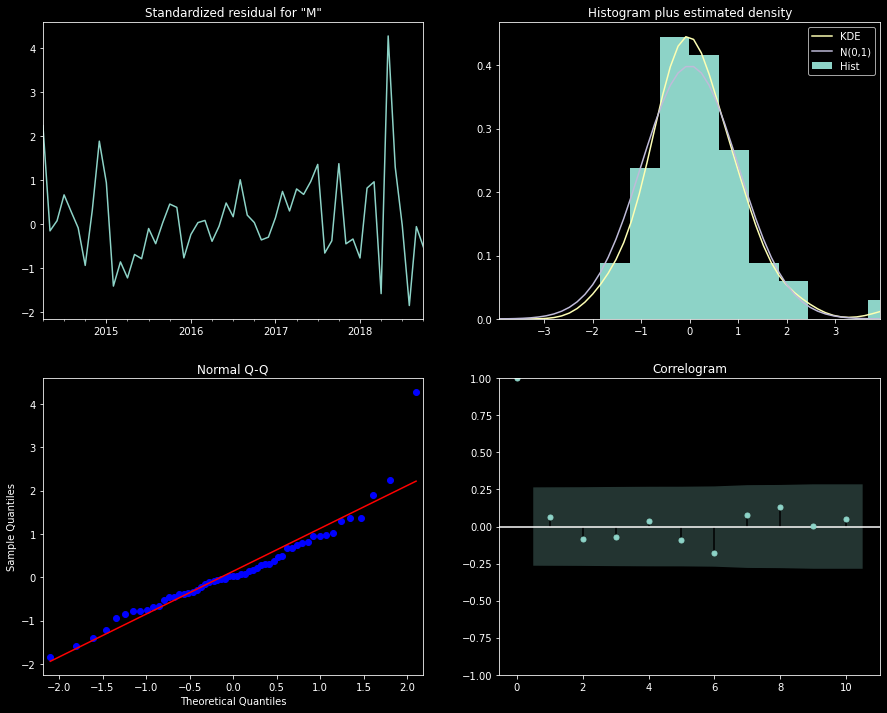

In [ ]:
# 생성된 모델 적합성 확인 과정
# Standardized residual: 잔차가 평균 0을 중심으로 백색잡음에 가까움
# Histogram plus estimated density: 잔차가 전반적으로 정규분포를 따르나 가운데 부분이 약간 벗어남
# Q-Q plot: 잔차가 전반적으로 정규분포를 따르나 하나의 관측치가 다소 분포에서 벗어남
# Correlogram(잔차에 대한 ACF): 모두 초록색 박스 안에 들어왔으므로 자기상관성이 없다고 판단할 수 있음
results.plot_diagnostics(figsize=(15, 12))
plt.show()

#### 3) 예측 및 Plotting

In [ ]:
df.head(5)

,M3
Date,
2012-01-01,27
2012-02-01,37
2012-03-01,8
2012-04-01,9
2012-05-01,11


In [ ]:
df.index.min(), df.index.max()

(Timestamp('2012-01-01 00:00:00'), Timestamp('2018-10-01 00:00:00'))

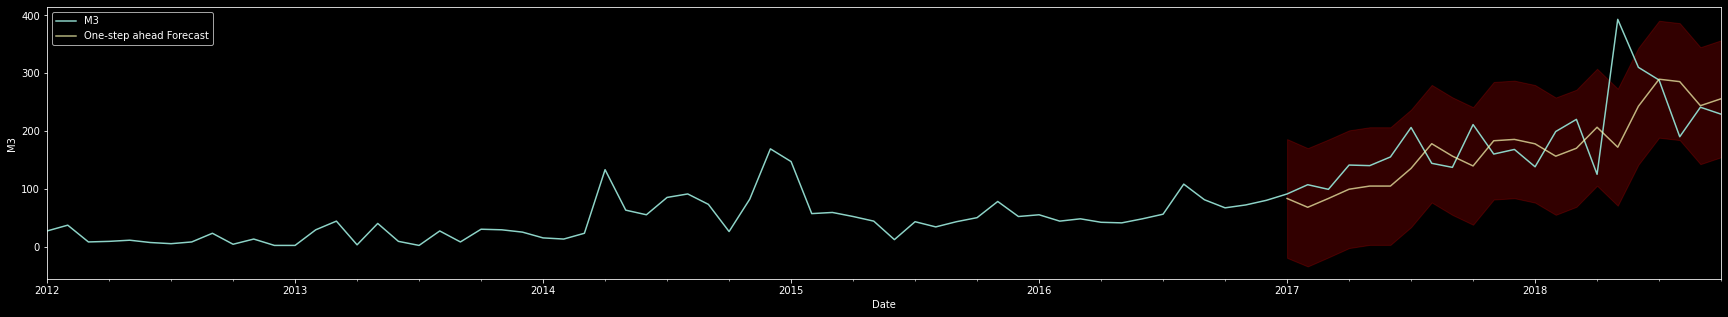

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2018-10-01'), dynamic=False)

pred_ci = pred.conf_int()
ax = df['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('M3')
plt.legend()

plt.rcParams["figure.figsize"] = (30, 5)
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = df['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth['M3']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

mae = (abs(y_forecasted - y_truth['M3'])).mean()
print('The MAE is {}'.format(round(mae, 2)))

The Mean Squared Error of our forecasts is 4345.03
The MAE is 47.93


In [ ]:
# 대체적으로 유사하게 예측되었으나, 2018년 5월 발주수량이 평소보다 유난히 높아 예측치가 다소 벗어난 모습
cols = ['y_truth','y_forecasted']
dat = []

result=pd.DataFrame(dat,columns=cols)

result['y_forecasted']=y_forecasted
result['y_truth']=y_truth['M3']
result['diff'] = result['y_truth'] - result['y_forecasted']
result

,y_truth,y_forecasted,diff
2017-01-01,91,83.175757,7.824243
2017-02-01,107,67.938830,39.061170
2017-03-01,99,83.200813,15.799187
2017-04-01,141,99.200742,41.799258
2017-05-01,140,104.656336,35.343664
2017-06-01,155,104.631222,50.368778
2017-07-01,206,135.285839,70.714161
2017-08-01,144,177.907443,-33.907443
2017-09-01,137,156.424170,-19.424170
2017-10-01,211,139.425423,71.574577
